# Section 3.2: Polynomial curve fitting (Analytical Solution VS FGD VS SGD)
## by Telmo Cunha

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1894)
#np.random.seed(987654)

### Experiments with ensembles

In [2]:
def g(x):
    return np.sin(2*np.pi*x)

In [3]:
def regularized_least_squares(phi,t,reg_lambda=0):
    
    W=np.zeros(M)
    
    if(N>=M):
        id_matrix=np.eye(M)
        aux1=reg_lambda*id_matrix+np.matmul(phi.T,phi)
        aux2=np.linalg.inv(aux1)
        W=np.matmul(np.matmul(aux2,phi.T),t.T)
    else:
        id_matrix=np.eye(N)
        aux1=reg_lambda*id_matrix+np.matmul(phi,phi.T)
        aux2=np.linalg.inv(aux1)
        W=np.matmul(np.matmul(phi.T,aux2),t)
    
    return W

In [4]:
def predictor(X,W):
    
    phi=np.zeros((len(X),M))
    
    for k in range(M):
        if (k==0):
            phi[:,k]=1
        else:
            phi[:,k]=np.power(X,k)
  
    Y=np.matmul(phi,W.T)
    
    return Y

In [5]:
def full_gradient_descent(Y_hat,phi,t,W,reg_lambda):
    
    gradient=np.zeros((M))
    
    aux1=(Y_hat-t).reshape((1,len(t)))
    aux2=np.matmul(aux1,phi)
    gradient=aux2+reg_lambda*W

    return (1/N)*gradient[0]

In [6]:
def stochastic_gradient_descent(Y_hat,phi,t,reg_lambda,batch_size,W,index_increase):
    
    gradient=np.zeros((M))
    
    # randomly selecting on dataset
    #datapoint_index=np.random.randint(0, high=N, size=batch_size, dtype=int)
    
    # passing through the entire dataset
    datapoint_index=np.arange(0, batch_size, dtype=int)+index_increase*batch_size
    
    batch_t=t[datapoint_index]
    batch_y=Y_hat[datapoint_index]
    
    aux1=(batch_y-batch_t).reshape((1,batch_size))
    aux2=np.dot(aux1,phi[datapoint_index])
    
    gradient=aux2+reg_lambda*W
    
    return (1/batch_size)*gradient[0]

In [7]:
def loss_function(Y_hat,t,W,reg_lambda):
    return 1/2*np.sum(np.power(Y_hat-t,2))+1/2*reg_lambda*np.dot(W,W)

In [8]:
# Ensemble size
ensemble_size=100

# Hyperparameters
max_epochs=5000
N=10
M=30
eta=0.01

test_set_size=100
# Generating Test Set
X_test=np.random.uniform(low=0.0, high=1.0, size=test_set_size)
epsilon=np.random.normal(loc=0.0, scale=0.15, size=test_set_size)
t_test=g(X_test)+epsilon

# Loss 
training_loss_fgd=np.zeros((max_epochs,ensemble_size))
training_loss_sgd=np.zeros((max_epochs,ensemble_size))
training_loss_batch_sgd=np.zeros((max_epochs,ensemble_size))
training_loss_analytical=[]
training_loss_analytical_reg=[]

test_loss_fgd=np.zeros((max_epochs,ensemble_size))
test_loss_sgd=np.zeros((max_epochs,ensemble_size))
test_loss_batch_sgd=np.zeros((max_epochs,ensemble_size))
test_loss_analytical=[]
test_loss_analytical_reg=[]

# Weight initialization
W_fgd=np.random.normal(0,1,M)
W_sgd=np.random.normal(0,1,M)
W_batch_sgd=np.random.normal(0,1,M)

weights_fgd_list=np.zeros((M,ensemble_size))
weights_sgd_list=np.zeros((M,ensemble_size))
weights_batch_sgd_list=np.zeros((M,ensemble_size))
weights_analytical_list=np.zeros((M,ensemble_size))
weights_analytical_reg_list=np.zeros((M,ensemble_size))

# Gradients for FGD
gradients_fgd=np.zeros((max_epochs,ensemble_size))

# Computing the Design matrix
phi=np.zeros((N,M))

for k in range(ensemble_size):
    
    X=np.random.uniform(low=0.0, high=1.0, size=N)
    epsilon=np.random.normal(loc=0.0, scale=0.15, size=N)
    t=g(X)+epsilon
    
    for i in range(M):
        if (i==0):
            phi[:,i]=1
        else:
            phi[:,i]=np.power(X,i)

    # Analytical Solution (without regularization)
    W_analytical=regularized_least_squares(phi,t,reg_lambda=0)
    training_loss_analytical.append((1/N)*loss_function(predictor(X,W_analytical),t,W_analytical,reg_lambda=0))
    test_loss_analytical.append((1/test_set_size)*loss_function(predictor(X_test,W_analytical),t_test,W_analytical,reg_lambda=0))
    
    # Analytical Solution (with regularization)
    W_analytical_reg=regularized_least_squares(phi,t,reg_lambda=0.0001)
    training_loss_analytical_reg.append((1/N)*loss_function(predictor(X,W_analytical_reg),t,W_analytical_reg,reg_lambda=0.0001))
    test_loss_analytical_reg.append((1/test_set_size)*loss_function(predictor(X_test,W_analytical_reg),t_test,W_analytical_reg,reg_lambda=0.0001))
    
    weights_analytical_list[:,k]=W_analytical
    weights_analytical_reg_list[:,k]=W_analytical_reg
    
    for epoch in range(max_epochs):
        
        reg_lambda=0
        
        # Full Gradient Descent
        Y_hat=np.matmul(phi,W_fgd.T)
        grd_fgd=full_gradient_descent(Y_hat,phi,t,W_fgd,reg_lambda)
        W_fgd+=-eta*grd_fgd
        training_loss_fgd[epoch,k]=(1/N)*loss_function(predictor(X,W_fgd),t,W_fgd,reg_lambda)
        test_loss_fgd[epoch,k]=(1/test_set_size)*loss_function(predictor(X_test,W_fgd),t_test,W_fgd,reg_lambda)
        
        gradients_fgd[epoch,k]=np.linalg.norm(grd_fgd)
        
        # On-line Stochastic Gradient Descent
        batch_size=1
        for j in range(N):
            Y_hat=np.matmul(phi,W_sgd.T)
            grd_sgd=stochastic_gradient_descent(Y_hat,phi,t,reg_lambda,batch_size,W_sgd,j)
            W_sgd+=-eta*grd_sgd
        training_loss_sgd[epoch,k]=(1/N)*loss_function(predictor(X,W_sgd),t,W_sgd,reg_lambda)
        test_loss_sgd[epoch,k]=(1/test_set_size)*loss_function(predictor(X_test,W_sgd),t_test,W_sgd,reg_lambda)
        
        # Batch=2 Stochastic Gradient Descent
        batch_size=5
        for j in range(int(N/batch_size)):
            Y_hat=np.matmul(phi,W_batch_sgd.T)
            grd_batch_sgd=stochastic_gradient_descent(Y_hat,phi,t,reg_lambda,batch_size,W_batch_sgd,j)
            W_batch_sgd+=-eta*grd_batch_sgd
        training_loss_batch_sgd[epoch,k]=(1/N)*loss_function(predictor(X,W_batch_sgd),t,W_batch_sgd,reg_lambda)
        test_loss_batch_sgd[epoch,k]=(1/test_set_size)*loss_function(predictor(X_test,W_batch_sgd),t_test,W_batch_sgd,reg_lambda)
        
    weights_fgd_list[:,k]=W_fgd
    weights_sgd_list[:,k]=W_sgd
    weights_batch_sgd_list[:,k]=W_batch_sgd
    
training_loss_fgd=(1/ensemble_size)*np.sum(training_loss_fgd,axis=1)
training_loss_sgd=(1/ensemble_size)*np.sum(training_loss_sgd,axis=1)
training_loss_batch_sgd=(1/ensemble_size)*np.sum(training_loss_batch_sgd,axis=1)

test_loss_fgd=(1/ensemble_size)*np.sum(test_loss_fgd,axis=1)
test_loss_sgd=(1/ensemble_size)*np.sum(test_loss_sgd,axis=1)
test_loss_batch_sgd=(1/ensemble_size)*np.sum(test_loss_batch_sgd,axis=1)

gradients_fgd=(1/ensemble_size)*np.sum(gradients_fgd,axis=1)

### Empirical/Test Risk plots


Training Loss of Analytical Solution: 0.02435
Test Loss of Analytical Solution: 14049283584.27644

Training Loss of Analytical Solution w/ Regularization: 0.00659
Test Loss of Analytical Solution w/ Regularization: 0.92904

Values after  5000 epochs:

Training Loss of FGD Solution: 0.0223
Test Loss of FGD Solution: 0.04905

Training Loss of SGD Solution: 0.00944
Test Loss of SGD Solution: 0.04546

Epoch with minimum test error on FGD: 324

Plot of the average loss over the ensemble:


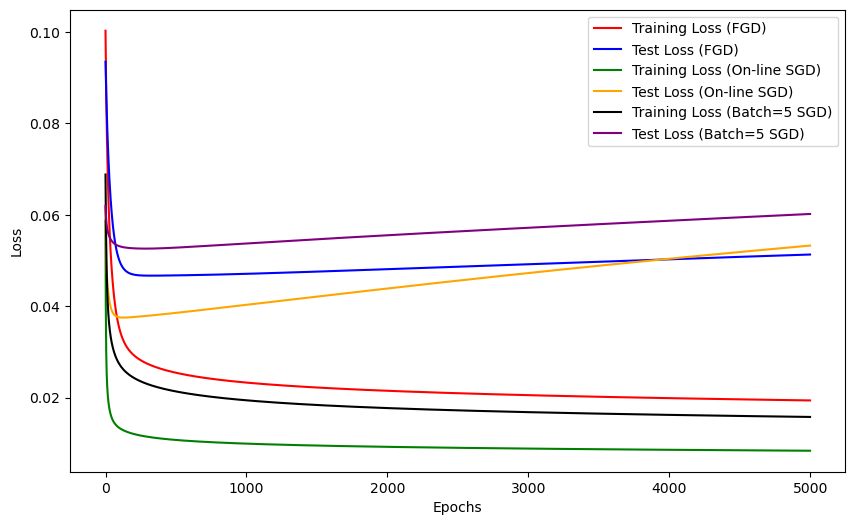

In [9]:
print("\nTraining Loss of Analytical Solution:", np.round(np.mean(training_loss_analytical),5))
print("Test Loss of Analytical Solution:", np.round(np.mean(test_loss_analytical),5))

print("\nTraining Loss of Analytical Solution w/ Regularization:", np.round(np.mean(training_loss_analytical_reg),5))
print("Test Loss of Analytical Solution w/ Regularization:", np.round(np.mean(test_loss_analytical_reg),5))

print("\nValues after ", max_epochs, "epochs:")

print("\nTraining Loss of FGD Solution:", np.round(np.mean(training_loss_fgd),5))
print("Test Loss of FGD Solution:", np.round(np.mean(test_loss_fgd),5))

print("\nTraining Loss of SGD Solution:", np.round(np.mean(training_loss_sgd),5))
print("Test Loss of SGD Solution:", np.round(np.mean(test_loss_sgd),5))

print("\nEpoch with minimum test error on FGD:",np.argmin(test_loss_fgd))

print("\nPlot of the average loss over the ensemble:")

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(max_epochs), training_loss_fgd, 'r-', label='Training Loss (FGD)')
ax.plot(range(max_epochs), test_loss_fgd, 'b-', label='Test Loss (FGD)')

ax.plot(range(max_epochs), training_loss_sgd, 'g-', label='Training Loss (On-line SGD)')
ax.plot(range(max_epochs), test_loss_sgd, c='orange', label='Test Loss (On-line SGD)')

ax.plot(range(max_epochs), training_loss_batch_sgd, 'black', label='Training Loss (Batch=5 SGD)')
ax.plot(range(max_epochs), test_loss_batch_sgd, c='purple', label='Test Loss (Batch=5 SGD)')

plt.ylabel('Loss')
plt.xlabel('Epochs')

ax.legend()
plt.show()

## Plots

### Analytical Solution with $\lambda=0$ (showing only 5 of the 10 ensembles)

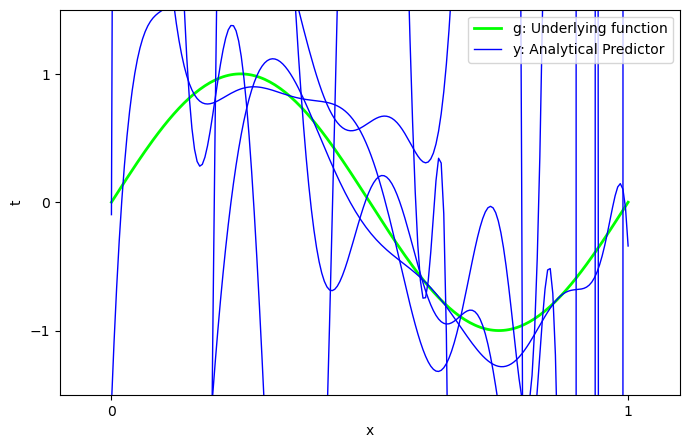

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

plot_list=np.random.choice(np.arange(ensemble_size), size=5, replace=False, p=None)

count=0
# Computing the predictors
for j in plot_list:
    Y_analytical=predictor(x2,weights_analytical_list[:,j])
    if count==0:
        ax.plot(x2, Y_analytical, linewidth=1.0, color="blue",label="y: Analytical Predictor")
        count+=1
    else:
        ax.plot(x2, Y_analytical, linewidth=1.0, color="blue")

plt.ylabel('t')
plt.xlabel('x')        
ax.legend();  # Add a legend.
plt.show()

### Analytical Solution with $\lambda=0.01$:

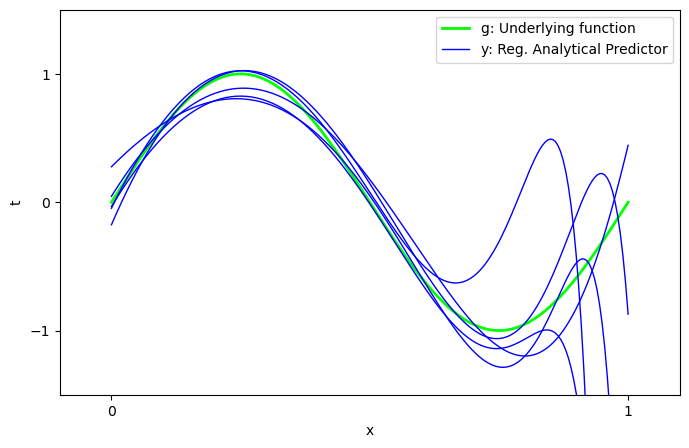

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

plot_list=np.random.choice(np.arange(ensemble_size), size=5, replace=False, p=None)

count=0
# Computing the predictors
for j in plot_list:
    Y_analytical_reg=predictor(x2,weights_analytical_reg_list[:,j])
    if count==0:
        ax.plot(x2, Y_analytical_reg, linewidth=1.0, color="blue",label="y: Reg. Analytical Predictor")
        count+=1
    else:
        ax.plot(x2, Y_analytical_reg, linewidth=1.0, color="blue")

plt.ylabel('t')
plt.xlabel('x')  
ax.legend();  # Add a legend.
plt.show()

### Taking the average predictor

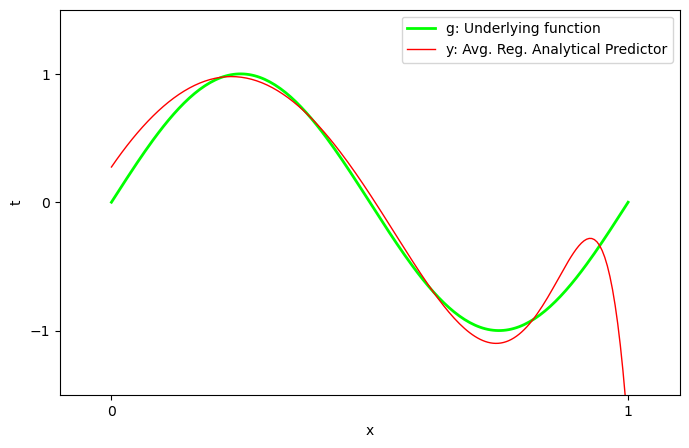

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

average_predictor=0
for i in range(ensemble_size):
    average_predictor+=(1/ensemble_size)*predictor(x2,weights_analytical_reg_list[:,i])

ax.plot(x2, average_predictor, linewidth=1.0, color="red",label="y: Avg. Reg. Analytical Predictor")

plt.ylabel('t')
plt.xlabel('x')  
ax.legend();  # Add a legend.
plt.show()

### Full Gradient Descent (FGD) Solution:

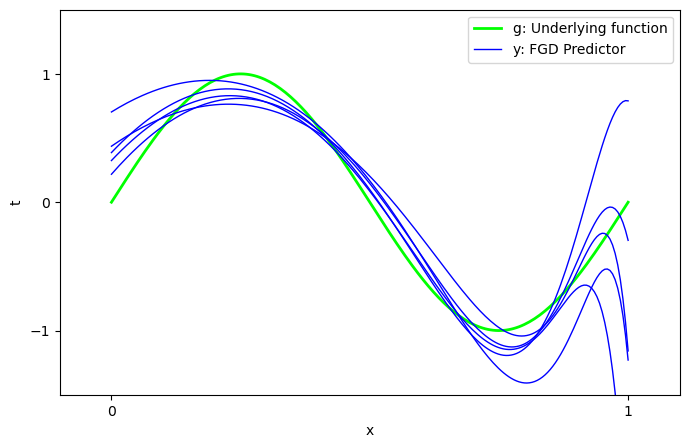

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

plot_list=np.random.choice(np.arange(ensemble_size), size=5, replace=False, p=None)

count=0
# Computing the predictors
for j in plot_list:
    Y_fgd=predictor(x2,weights_fgd_list[:,j])
    if count==0:
        ax.plot(x2, Y_fgd, linewidth=1.0, color="blue",label="y: FGD Predictor")
        count+=1
    else:
        ax.plot(x2, Y_fgd, linewidth=1.0, color="blue")

plt.ylabel('t')
plt.xlabel('x')  
ax.legend();  # Add a legend.
plt.show()

### On-line Stochastic Gradient Descent (SGD) Solution:

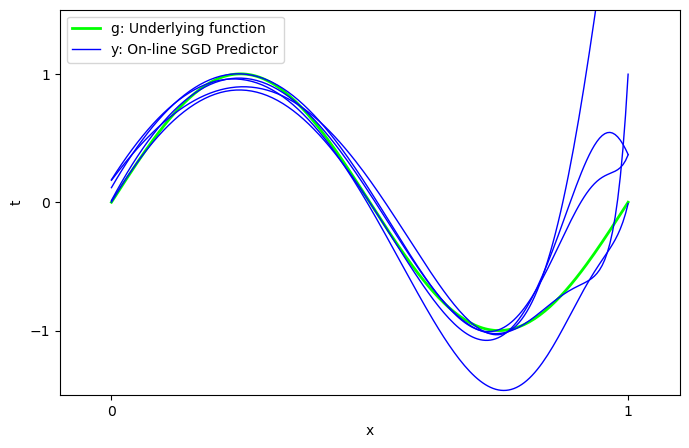

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

plot_list=np.random.choice(np.arange(ensemble_size), size=5, replace=False, p=None)

count=0
# Computing the predictors
for j in plot_list:
    Y_sgd=predictor(x2,weights_sgd_list[:,j])
    if count==0:
        ax.plot(x2, Y_sgd, linewidth=1.0, color="blue",label="y: On-line SGD Predictor")
        count+=1
    else:
        ax.plot(x2, Y_sgd, linewidth=1.0, color="blue")

plt.ylabel('t')
plt.xlabel('x')  
ax.legend();  # Add a legend.

plt.show()

### (Batch=5) SGD Solution:

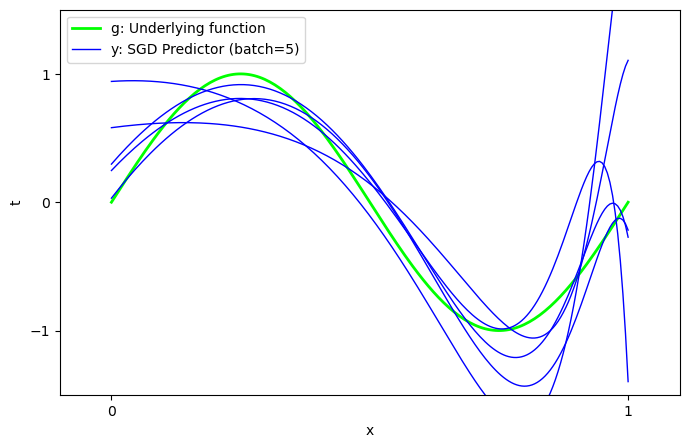

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set(xlim=(-0.1, 1.1), xticks=np.arange(0, 1.1),
       ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.1,1))

x2 = np.linspace(0, 1, 200)
y2 = g(x2)

# underlying function
ax.plot(x2, y2, linewidth=2.0, color="lime",label="g: Underlying function")

plot_list=np.random.choice(np.arange(ensemble_size), size=5, replace=False, p=None)

count=0
# Computing the predictors
for j in plot_list:
    Y_batch_sgd=predictor(x2,weights_batch_sgd_list[:,j])
    if count==0:
        ax.plot(x2, Y_batch_sgd, linewidth=1.0, color="blue",label="y: SGD Predictor (batch=5)")
        count+=1
    else:
        ax.plot(x2, Y_batch_sgd, linewidth=1.0, color="blue")

plt.ylabel('t')
plt.xlabel('x')  
ax.legend();  # Add a legend.

plt.show()

### Weight norms

In [16]:
print("Norm of Analytical (lambda=0) weights:", np.linalg.norm(weights_analytical_list[-1]))
print("Norm of Analytical (lambda=0.01) weights:", np.linalg.norm(weights_analytical_reg_list[-1]))
print("Norm of on-line SGD weights:", np.linalg.norm(weights_sgd_list[-1]))
print("Norm of FGD weights:", np.linalg.norm(weights_fgd_list[-1]))
print("Norm of on-line SGD weights:", np.linalg.norm(weights_sgd_list[-1]))
print("Norm of batch SGD weights:", np.linalg.norm(weights_batch_sgd_list[-1]))

Norm of Analytical (lambda=0) weights: 3167552.418400092
Norm of Analytical (lambda=0.01) weights: 14.115196331502258
Norm of on-line SGD weights: 15.941945245448569
Norm of FGD weights: 17.688940581224685
Norm of on-line SGD weights: 15.941945245448569
Norm of batch SGD weights: 13.417566852989125


### Average Gradient Norm Plot

Norm value at last epoch: 0.006


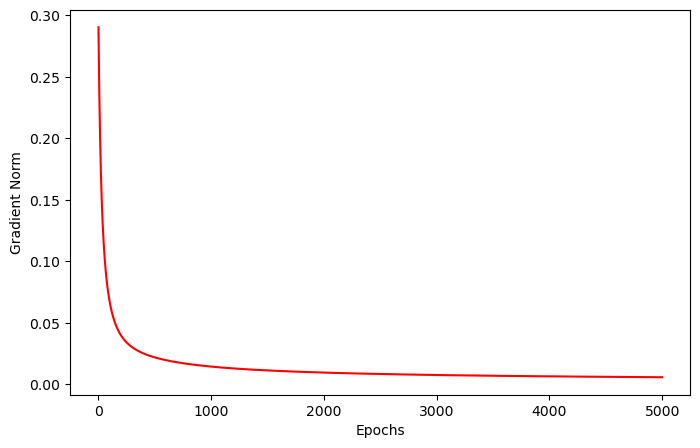

In [17]:
print("Norm value at last epoch:",np.round(gradients_fgd[-1],3))

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(range(max_epochs), gradients_fgd, 'red')

plt.ylabel('Gradient Norm')
plt.xlabel('Epochs')

plt.show()